## Cryptocurrency trading-pair forecasting, using machine learning and deep learning Technique - *Osifo Ernest and Ritabrata Bhattacharyya* 

###### An effort to recreate the research findings - Part II

## 1. Developing a Proposed Trading Strategy

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import yfinance as yf 
%matplotlib inline 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
np.random.seed(0) 
plt.style.use('seaborn-v0_8-dark') 

import warnings 
warnings.filterwarnings('ignore') 

In [2]:
start_date = '2018-01-01'
end_date = '2019-09-01' 

In [3]:
crypto_pair = pd.DataFrame() 
crypto_pair['BTC_Adj_Close'] = yf.download('BTC-USD',start=start_date,end=end_date)['Adj Close'] 
crypto_pair['ETH_Adj_Close'] = yf.download('ETH-USD',start=start_date,end=end_date)['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
crypto_pair.head() 

,BTC_Adj_Close,ETH_Adj_Close
Date,,
2018-01-01,13657.200195,772.640991
2018-01-02,14982.099609,884.443970
2018-01-03,15201.000000,962.719971
2018-01-04,15599.200195,980.921997
2018-01-05,17429.500000,997.719971


## 2. Calculating Returns

In [5]:
pair_ret = crypto_pair.pct_change(1).dropna() 
pair_ret.columns = ['BTC_RET','ETH_RET'] 
pair_ret.head()  

,BTC_RET,ETH_RET
Date,,
2018-01-02,0.097011,0.144702
2018-01-03,0.014611,0.088503
2018-01-04,0.026196,0.018907
2018-01-05,0.117333,0.017125
2018-01-06,0.005594,0.044061


## 3. Calculating Cumulative Returns

In [6]:
pair_cumret = crypto_pair.pct_change(1).cumsum().dropna() 
pair_cumret.columns = ['BTC_CRET','ETH_CRET'] 
pair_cumret.head()  

,BTC_CRET,ETH_CRET
Date,,
2018-01-02,0.097011,0.144702
2018-01-03,0.111622,0.233205
2018-01-04,0.137818,0.252112
2018-01-05,0.255150,0.269237
2018-01-06,0.260744,0.313298


## 4. Split into Train and Testing

In [7]:
btc_R_train = pair_ret['BTC_RET'][:488] 
eth_R_train = pair_ret['ETH_RET'][:488] 
btc_R_test = pair_ret['BTC_RET'][488:] 
eth_R_test = pair_ret['ETH_RET'][488:] 
pair_test = pd.concat([btc_R_test,eth_R_test],ignore_index=False,axis=1) 
pair_test.head() 

,BTC_RET,ETH_RET
Date,,
2019-05-05,-0.006081,-0.003511
2019-05-06,-0.008438,0.056301
2019-05-07,0.014390,-0.016533
2019-05-08,0.026238,0.006770
2019-05-09,0.032106,-0.003854


#### Formula for the calculations of spread, Z-score for spread and Rolling Spread Z-score

$$S_t=y_t-\beta x_t$$
$S_t = $ Spread at time t <br>
$y_t = $ Bitcoin price at time t <br>
$\beta = $ zero intercept linear regression coefficient also known as hedge <br>
$x_t = $ Ethereum price at time t 

$$Z(S)_t = \dfrac{S_t-\mu S_t}{\sigma S_t}$$ 
$Z(S)_t = $ Z-score of the spread in time t <br>
$S_t = $ Spread in time t <br>
$\mu S_t = $ Mean of the spread in time t <br>
$\sigma S_t = $ Standard Deviation of the spread in time t 

$$Z(S)_{window=55} = \dfrac{S_t - \mu S_{window=55}}{\sigma S_{window=55}}$$  
$Z(S)_{window=55} = $ Z-score of the spread with 55 day window <br>
$S_t = $ Spread in time <br> 
$\mu S_{window=55} = $ Mean of the spread with 55 day window <br> 
$\sigma S_{window=55} = $ Standard Deviation of the spread with 55 day window 

## 5. Calculating the Spread and Hedge

In [8]:
import statsmodels.regression.linear_model as rg 

In [9]:
pair_spread = btc_R_test - rg.OLS(btc_R_train,eth_R_train).fit().params[0]*eth_R_test
beta = rg.OLS(btc_R_train,eth_R_train).fit().params[0] 
beta  

0.6116786809043478

## 6. Pairs Spread Plot

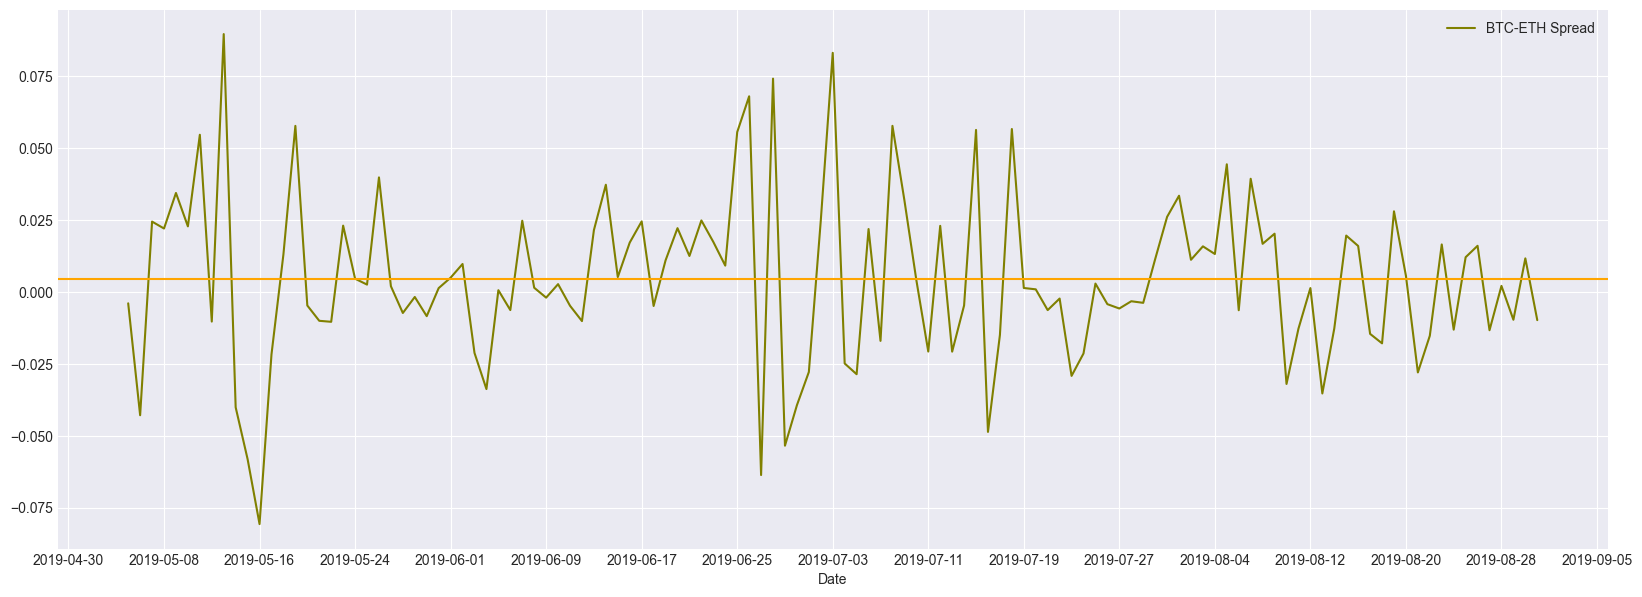

In [10]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(pair_spread,color='olive',label='BTC-ETH Spread')
ax.axhline(pair_spread.mean(),color='orange') 
ax.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date') 
plt.legend(loc='best') 
plt.show()

## 7. ACF and PACF for pair spread

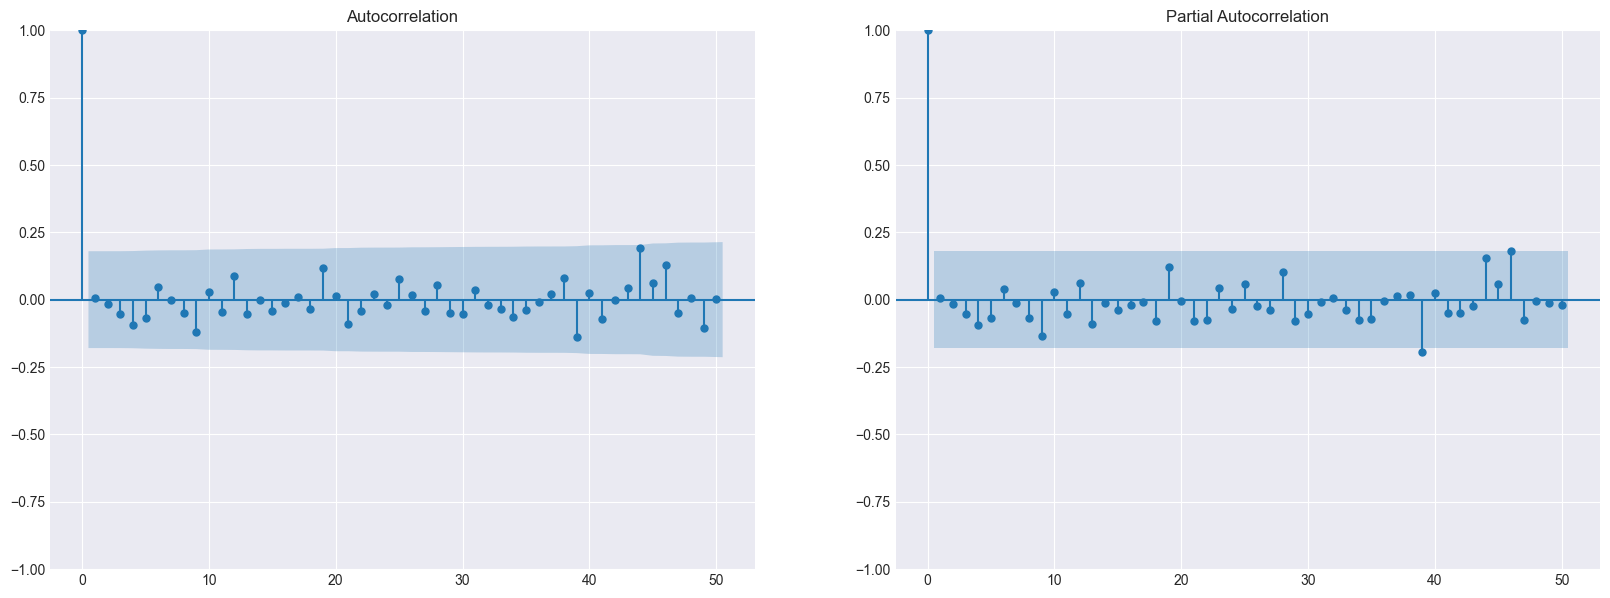

In [11]:
fig, axs = plt.subplots(1,2,figsize=(20,7)) 

plot_acf(pair_spread, lags=50, ax=axs[0])
axs[0].grid(True)

plot_pacf(pair_spread, lags=50, ax=axs[1])
axs[1].grid(True)

plt.show() 

## 8. ACF and PACF for pair spread^2

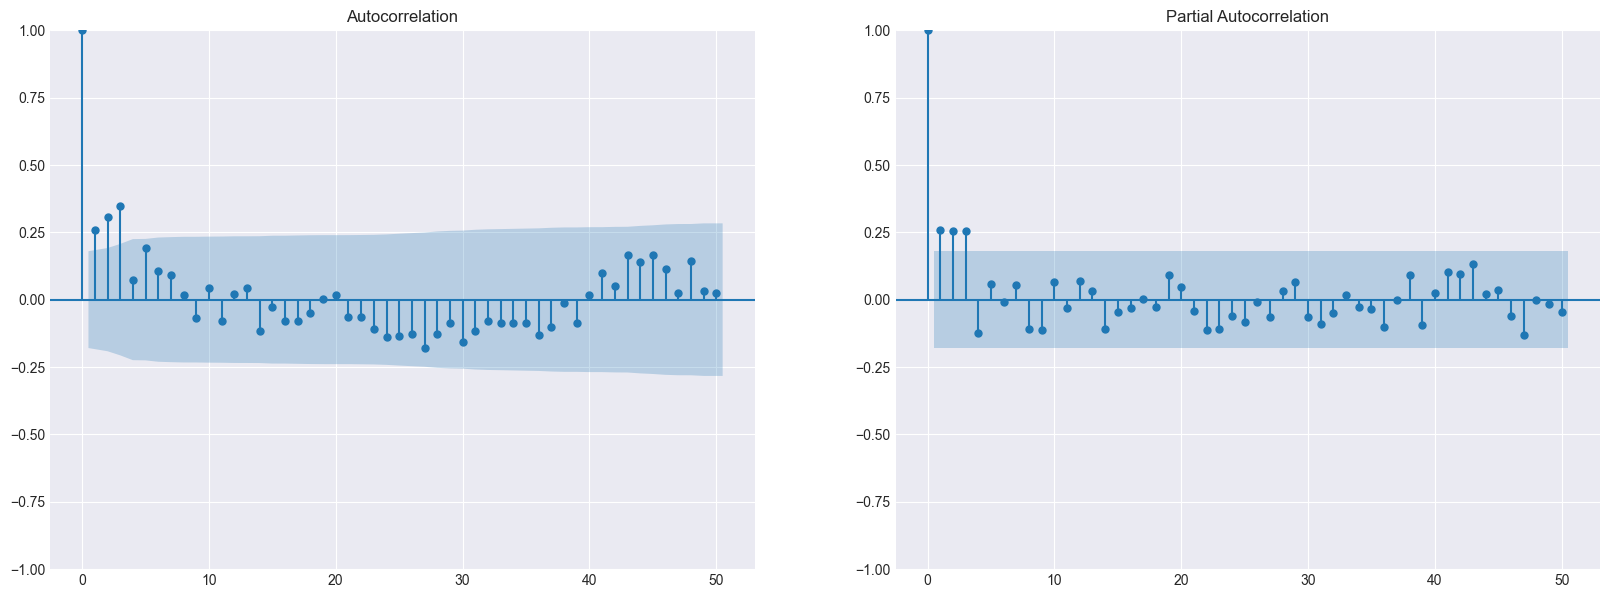

In [12]:
fig, axs = plt.subplots(1,2,figsize=(20,7)) 

plot_acf(pair_spread**2, lags=50, ax=axs[0])
axs[0].grid(True)

plot_pacf(pair_spread**2, lags=50, ax=axs[1])
axs[1].grid(True)

plt.show() 

## 9. Augmented Dickey-Fuller Test

BTC-ETH Spread Augmented Dickey-Fuller Co-Integration Test and new_spread Phillips-Perron Co-Integration Test

In [13]:
import arch.unitroot as at  

In [14]:
print('== BTC-ETH Spread Augmented Dickey-Fuller Co-Integration Test ==')
print( ) 
print(at.ADF(pair_spread, trend='ct')) 
print() 
print('== BTC-ETH new_spread Phillips-Perron Co-Integration Test ==')
print( ) 
print(at.PhillipsPerron(pair_spread, trend='ct', test_type='rho')) 

== BTC-ETH Spread Augmented Dickey-Fuller Co-Integration Test ==

   Augmented Dickey-Fuller Results   
Test Statistic                -10.672
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

== BTC-ETH new_spread Phillips-Perron Co-Integration Test ==

     Phillips-Perron Test (Z-rho)    
Test Statistic                -93.747
P-value                         0.000
Lags                               13
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -27.47 (1%), -20.64 (5%), -17.48 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## 10. Calculating Mean and Standard Deviation

In [15]:
spread_mean = pair_spread.mean() 
spread_sd = pair_spread.std() 

print('The mean of the spread = ',spread_mean) 
print('The Standard Deviation of the spread = ',spread_sd) 

The mean of the spread =  0.004378346601822491
The Standard Deviation of the spread =  0.02922867808147622


## 11. Z-Score Calculation

z_score = (pair_spread-spread_mean)/spread_sd

In [16]:
window = 55 
pair_train = btc_R_test-rg.OLS(btc_R_train,eth_R_train).fit().params[0]*eth_R_test

BTC-ETH Rolling Spread Z-Score Calculation

In [17]:
z_score = (pair_train-pair_train.rolling(window=window).mean())
len(z_score) 

119

## 12. Plotting Z-Score

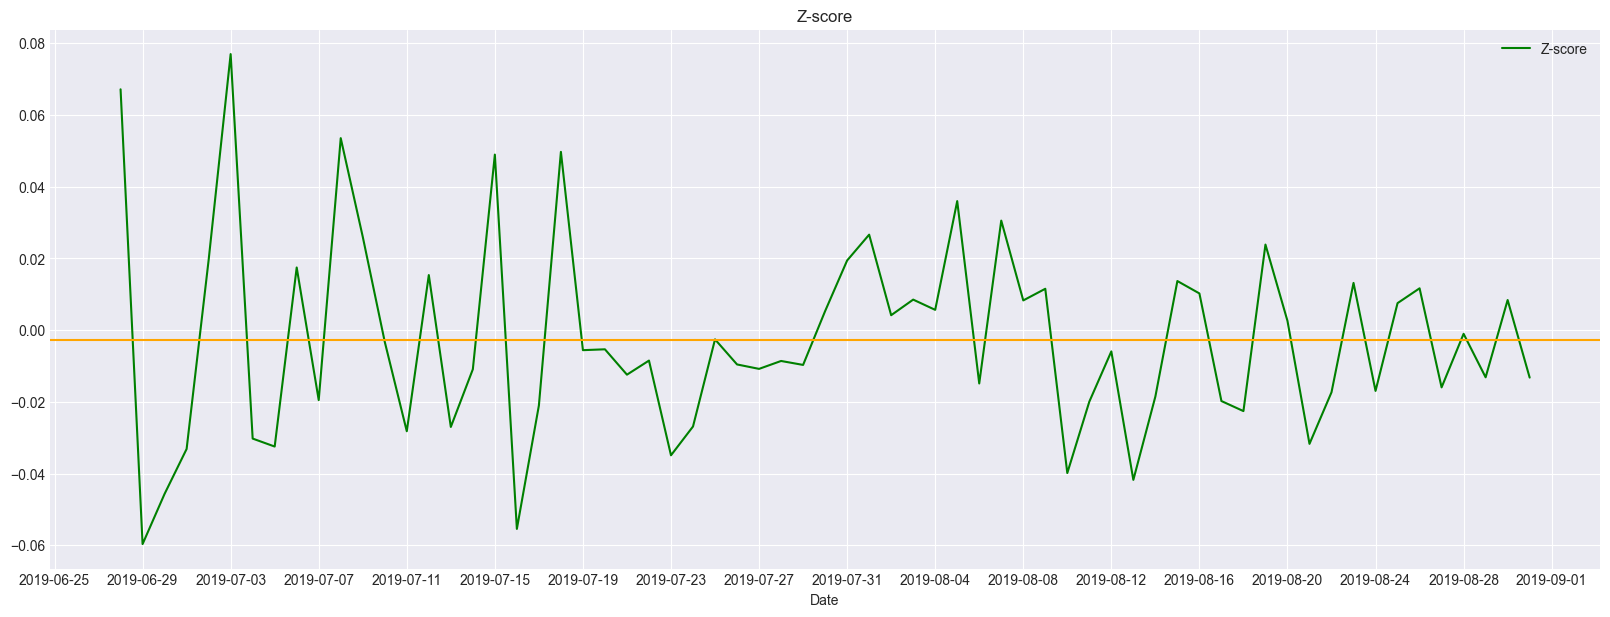

In [18]:
plt.figure(figsize=(20,7)) 
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.plot(z_score,color='green',label='Z-score')
plt.title('Z-score')
ax.axhline(z_score.mean(), color='orange')
ax.grid(True)
plt.xlabel("Date") 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(loc='best')
plt.show()

## 13. Plotting Z-score with Threshold

Calculating Threshold

In [19]:
up_th = (z_score.rolling(window=2).mean())+(z_score.rolling(window=2).std()*2) # upper threshold
lw_th = (z_score.rolling(window=2).mean())-(z_score.rolling(window=2).std()*2) # lower threshold

len(lw_th) 

119

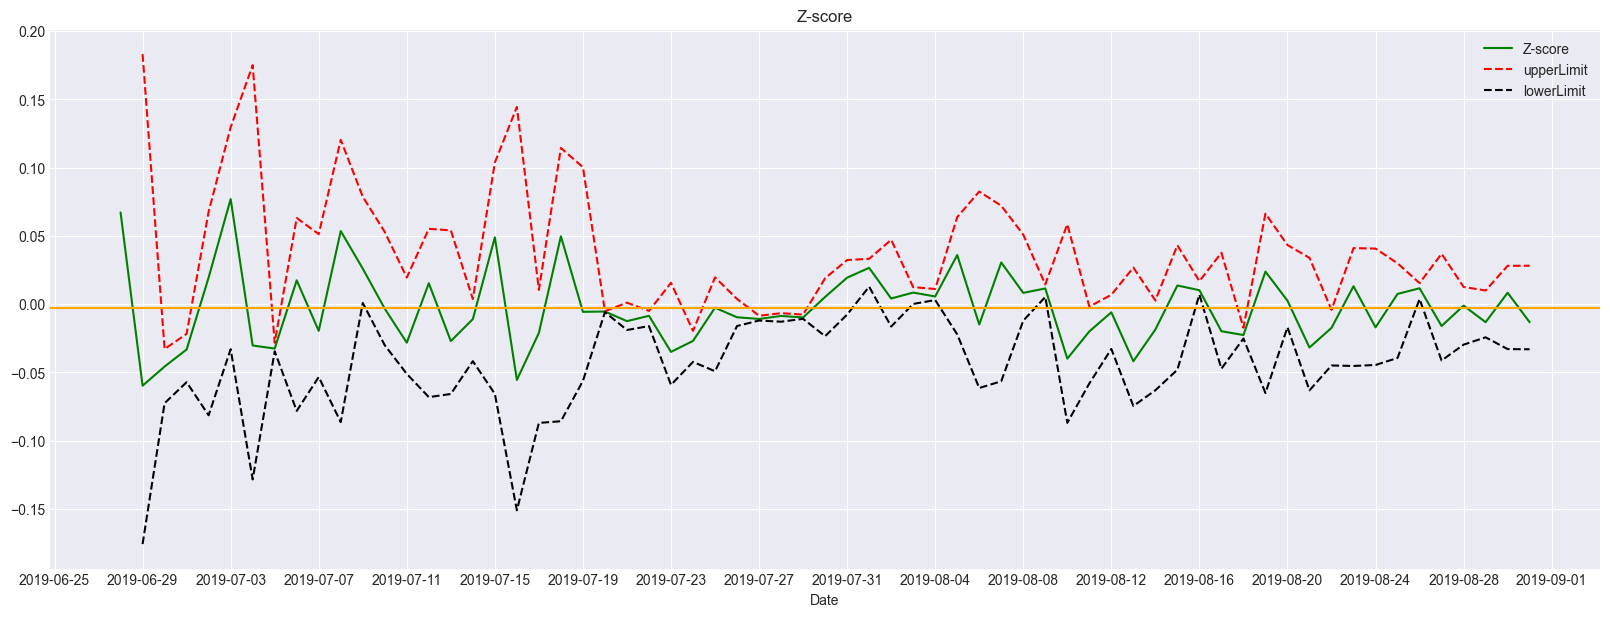

In [20]:
plt.figure(figsize=(20,7))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.plot(z_score,color='green',label='Z-score')
plt.plot(up_th,color='red',linestyle='--', label='upperLimit')
plt.plot(lw_th,color='black',linestyle='--', label='lowerLimit')
plt.title('Z-score')
ax.axhline(z_score.mean(), color='orange')
ax.grid(True)
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend(loc='best')
plt.show()

## 14. Calculating Returns on returns to build signals

Picking last 120 values of BTC and ETH 

In [21]:
rbtc_ret = pair_ret['BTC_RET'].tail(120) 
reth_ret = pair_ret['ETH_RET'].tail(120) 

rrbtc = (pair_ret['BTC_RET'].pct_change(1).dropna()).pct_change(1).dropna().tail(120) 
rreth = (pair_ret['ETH_RET'].pct_change(1).dropna()).pct_change(1).dropna().tail(120) 

In [22]:
trade_dir = pd.DataFrame(rbtc_ret) 

trade_dir.insert(len(trade_dir.columns),'rbtc_ret(-1)',rbtc_ret.shift(1)) 
trade_dir.insert(len(trade_dir.columns),'rbtc_ret(-2)',rbtc_ret.shift(2)) 
trade_dir.insert(len(trade_dir.columns),'reth_ret(-1)',rbtc_ret.shift(1)) 
trade_dir.insert(len(trade_dir.columns),'reth_ret(-2)',rbtc_ret.shift(2)) 
trade_dir.insert(len(trade_dir.columns),'rrbtc(-1)',rrbtc.shift(1))
trade_dir.insert(len(trade_dir.columns),'rrbtc(-2)',rrbtc.shift(2))
trade_dir.insert(len(trade_dir.columns),'rreth(-1)',rreth.shift(1))
trade_dir.insert(len(trade_dir.columns),'rreth(-2)',rreth.shift(2)) 

trade_dirsig2 = 0.0
trade_dirsig2a = [] 

for i in trade_dir.index.values:
    if trade_dir.at[i,'rrbtc(-2)']>(rreth[i]) and trade_dir.at[i,'rrbtc(-1)']<(rreth[i]):
        trade_dirsig2 = 2 
    elif trade_dir.at[i,'rrbtc(-2)']<(rreth[i]) and trade_dir.at[i,'rrbtc(-1)']>(rreth[i]):
        trade_dirsig2 = -2
    elif trade_dir.at[i,'rreth(-2)']>(rrbtc[i]) and trade_dir.at[i,'rreth(-1)']<(rrbtc[i]):
        trade_dirsig2 = 1
    elif trade_dir.at[i,'rreth(-2)']<(rrbtc[i]) and trade_dir.at[i,'rreth(-1)']<(rrbtc[i]):
        trade_dirsig2 = -1
    else:
        trade_dirsig2 = 0.0 
    trade_dirsig2a.append(trade_dirsig2) 
trade_dir.insert(len(trade_dir.columns),'trade_dirsig2',trade_dirsig2a)         

## 15. Trading Strategy Signals 

In [23]:
pair_test.insert(len(pair_test.columns), 'z_score', z_score)
pair_test.insert(len(pair_test.columns), 'z_score(-1)', z_score.shift(1))
pair_test.insert(len(pair_test.columns), 'z_score(-2)', z_score.shift(2))
pair_test.insert(len(pair_test.columns), 'trade_dir', trade_dir['trade_dirsig2'])

ftestsig2 = 0.0
ftestsig2a = []

for i in pair_test.index.values:
    if pair_test.at[i, 'z_score(-2)'] > (-1*up_th[i]) and pair_test.at[i, 'z_score(-1)'] < (-1*up_th[i]):
        ftestsig2 = 1
    elif pair_test.at[i, 'z_score(-2)'] < (-1*lw_th[i]) and pair_test.at[i, 'z_score(-1)'] > (-1*lw_th[i]):
        ftestsig2 = -2
    elif pair_test.at[i, 'z_score(-2)'] < (-1*up_th[i]) and pair_test.at[i, 'z_score(-1)'] > (-1*up_th[i]):
        ftestsig2 = -1
    elif pair_test.at[i, 'z_score(-2)'] > (-1*lw_th[i]) and pair_test.at[i, 'z_score(-1)'] < (-1*lw_th[i]):
        ftestsig2 = 2
    elif pair_test.at[i, 'z_score(-2)'] < up_th[i] and pair_test.at[i, 'z_score(-1)'] > up_th[i]:
        ftestsig2 = -1
    elif pair_test.at[i, 'z_score(-2)'] > up_th[i] and pair_test.at[i, 'z_score(-1)'] < up_th[i]:
        ftestsig2 = 1
    elif pair_test.at[i, 'z_score(-2)'] > lw_th[i] and pair_test.at[i, 'z_score(-1)'] < lw_th[i]:
        ftestsig2 = 2
    elif pair_test.at[i, 'z_score(-2)'] < lw_th[i] and pair_test.at[i, 'z_score(-1)'] > lw_th[i]:
        ftestsig2 = -2
    elif pair_test.at[i, 'trade_dir'] ==1:
        ftestsig2 = 2
    elif pair_test.at[i, 'trade_dir'] == -1:
        ftestsig2 = -2
    elif pair_test.at[i, 'trade_dir'] == 2:
        ftestsig2 = 1
    elif pair_test.at[i, 'trade_dir']== -2:
        ftestsig2 = -1
    else:
        ftestsig2 = 0.0
    ftestsig2a.append(ftestsig2)
pair_test.insert(len(pair_test.columns), 'ftestsig2', ftestsig2a)



print('== BTC_ETH Trading Strategy Signals ==')
print('')
print(pair_test.loc['2019-05-13':, ['z_score', 'ftestsig2']])
print('')


== BTC_ETH Trading Strategy Signals ==

             z_score  ftestsig2
Date                           
2019-05-13       NaN        1.0
2019-05-14       NaN       -1.0
2019-05-15       NaN        1.0
2019-05-16       NaN        0.0
2019-05-17       NaN        2.0
...              ...        ...
2019-08-27 -0.015982       -1.0
2019-08-28 -0.001049        1.0
2019-08-29 -0.013175       -1.0
2019-08-30  0.008375       -2.0
2019-08-31 -0.013251        0.0

[111 rows x 2 columns]



## 16. Testing Trading Logic

In [24]:
(pair_test.loc['2019-05-13':,['z_score','ftestsig2']]).tail(15)

,z_score,ftestsig2
Date,,
2019-08-17,-0.019792,-1.0
2019-08-18,-0.022598,1.0
2019-08-19,0.023839,2.0
2019-08-20,0.002555,-2.0
2019-08-21,-0.031733,0.0
2019-08-22,-0.017350,1.0
2019-08-23,0.013151,-2.0
2019-08-24,-0.016970,-1.0
2019-08-25,0.007508,0.0


In [25]:
pair_test.insert(len(pair_test.columns), 'rbtc_ret', rbtc_ret)
pair_test.insert(len(pair_test.columns), 'reth_ret', reth_ret)
pair_test.head() 

,BTC_RET,ETH_RET,z_score,z_score(-1),z_score(-2),trade_dir,ftestsig2,rbtc_ret,reth_ret
Date,,,,,,,,,
2019-05-05,-0.006081,-0.003511,NaN,NaN,NaN,0.0,0.0,-0.006081,-0.003511
2019-05-06,-0.008438,0.056301,NaN,NaN,NaN,0.0,0.0,-0.008438,0.056301
2019-05-07,0.014390,-0.016533,NaN,NaN,NaN,2.0,1.0,0.014390,-0.016533
2019-05-08,0.026238,0.006770,NaN,NaN,NaN,0.0,0.0,0.026238,0.006770
2019-05-09,0.032106,-0.003854,NaN,NaN,NaN,0.0,0.0,0.032106,-0.003854


In [26]:
crypto_pair.head() 

,BTC_Adj_Close,ETH_Adj_Close
Date,,
2018-01-01,13657.200195,772.640991
2018-01-02,14982.099609,884.443970
2018-01-03,15201.000000,962.719971
2018-01-04,15599.200195,980.921997
2018-01-05,17429.500000,997.719971


## 17. Trading Strategy Signals without commission/exchange fee

In [27]:
port_out = 0.0 
port_outa = [] 

for i in pair_test.index.values:
    if pair_test.at[i,'ftestsig2'] == -2:
        port_out = pair_test.at[i,'rbtc_ret'] 
    elif pair_test.at[i,'ftestsig2'] == -1:
        port_out = pair_test.at[i,'reth_ret'] 
    elif pair_test.at[i,'ftestsig2'] == 2:
        port_out = pair_test.at[i,'rbtc_ret'] 
    elif pair_test.at[i,'ftestsig2'] == 1:
        port_out = pair_test.at[i,'reth_ret'] 
    else:
        port_out = pair_test.at[i,'rbtc_ret'] 
    port_outa.append(port_out) 
pair_test.insert(len(pair_test.columns),'port_out',port_outa) 
pair_test = pair_test.fillna(method='ffill') 

port_outc = 0.0 
port_outca = [] 
com = 0.05 # with 5% commission 

for i in pair_test.index.values:
    if pair_test.at[i,'ftestsig2'] == -2:
        port_outc = ((pair_test.at[i,'rbtc_ret'])-abs(com*((pair_test.at[i,'rbtc_ret'])-(pair_test.at[i,'reth_ret'])))) 
    elif pair_test.at[i,'ftestsig2'] == -1:
        port_outc = ((pair_test.at[i,'reth_ret'])-abs(com*((pair_test.at[i,'rbtc_ret'])-(pair_test.at[i,'reth_ret'])))) 
    elif pair_test.at[i,'ftestsig2'] == 2:
        port_outc = ((pair_test.at[i,'rbtc_ret'])-abs(com*((pair_test.at[i,'rbtc_ret'])-(pair_test.at[i,'reth_ret'])))) 
    elif pair_test.at[i,'ftestsig2'] == 1:
        port_outc = ((pair_test.at[i,'reth_ret'])-abs(com*((pair_test.at[i,'rbtc_ret'])-(pair_test.at[i,'reth_ret'])))) 
    else:
        port_outc = ((pair_test.at[i,'rbtc_ret'])-abs(com*((pair_test.at[i,'rbtc_ret'])-(pair_test.at[i,'reth_ret'])))) 
    port_outca.append(port_outc) 

pair_test.insert(len(pair_test.columns),'port_outc',port_outca) 
pair_test = pair_test.fillna(method='ffill') 

print('== BTC_ETH Trading Strategy Position ==')
print('')
print(pair_test.loc['2019-05-13':, ['z_score', 'ftestsig2', 'port_out', 'port_outc']])
print('') 

== BTC_ETH Trading Strategy Position ==

             z_score  ftestsig2  port_out  port_outc
Date                                                
2019-05-13       NaN        1.0  0.050826   0.047325
2019-05-14       NaN       -1.0  0.103138   0.099129
2019-05-15       NaN        1.0  0.138175   0.132584
2019-05-16       NaN        0.0 -0.039031  -0.044393
2019-05-17       NaN        2.0 -0.068614  -0.069017
...              ...        ...       ...        ...
2019-08-27 -0.015982       -1.0 -0.007478  -0.007997
2019-08-28 -0.001049        1.0 -0.072669  -0.074187
2019-08-29 -0.013175       -1.0 -0.025149  -0.025155
2019-08-30  0.008375       -2.0  0.009250   0.008587
2019-08-31 -0.013251        0.0  0.003385   0.002478

[111 rows x 4 columns]



In [28]:
trade_dir.head() 

,BTC_RET,rbtc_ret(-1),rbtc_ret(-2),reth_ret(-1),reth_ret(-2),rrbtc(-1),rrbtc(-2),rreth(-1),rreth(-2),trade_dirsig2
Date,,,,,,,,,,
2019-05-04,0.010901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2019-05-05,-0.006081,0.010901,NaN,0.010901,NaN,-1.509128,NaN,-1.480632,NaN,0.0
2019-05-06,-0.008438,-0.006081,0.010901,-0.006081,0.010901,1.018398,-1.509128,-0.484987,-1.480632,0.0
2019-05-07,0.014390,-0.008438,-0.006081,-0.008438,-0.006081,-1.248762,1.018398,19.047299,-0.484987,2.0
2019-05-08,0.026238,0.014390,-0.008438,0.014390,-0.008438,-7.981147,-1.248762,-0.924064,19.047299,0.0


In [29]:
pair_test.head() 

,BTC_RET,ETH_RET,z_score,z_score(-1),z_score(-2),trade_dir,ftestsig2,rbtc_ret,reth_ret,port_out,port_outc
Date,,,,,,,,,,,
2019-05-05,-0.006081,-0.003511,NaN,NaN,NaN,0.0,0.0,-0.006081,-0.003511,-0.006081,-0.006209
2019-05-06,-0.008438,0.056301,NaN,NaN,NaN,0.0,0.0,-0.008438,0.056301,-0.008438,-0.011674
2019-05-07,0.014390,-0.016533,NaN,NaN,NaN,2.0,1.0,0.014390,-0.016533,-0.016533,-0.018080
2019-05-08,0.026238,0.006770,NaN,NaN,NaN,0.0,0.0,0.026238,0.006770,0.026238,0.025265
2019-05-09,0.032106,-0.003854,NaN,NaN,NaN,0.0,0.0,0.032106,-0.003854,0.032106,0.030308


Pair Trading Return 

In [30]:
pt_out = np.exp(np.log1p(pair_test['port_out']).cumsum())-1

Pair Trading with 5% commission return

In [31]:
pt_outc = np.exp(np.log1p(pair_test['port_outc']).cumsum())-1

Buy and Hold Bitcoin

In [32]:
bh_btc = np.exp(np.log1p(pair_test['rbtc_ret']).cumsum())-1

Buy and Hold Ethereum

In [33]:
bh_eth = np.exp(np.log1p(pair_test['reth_ret']).cumsum())-1

## 18. Portfolio Returns Chart

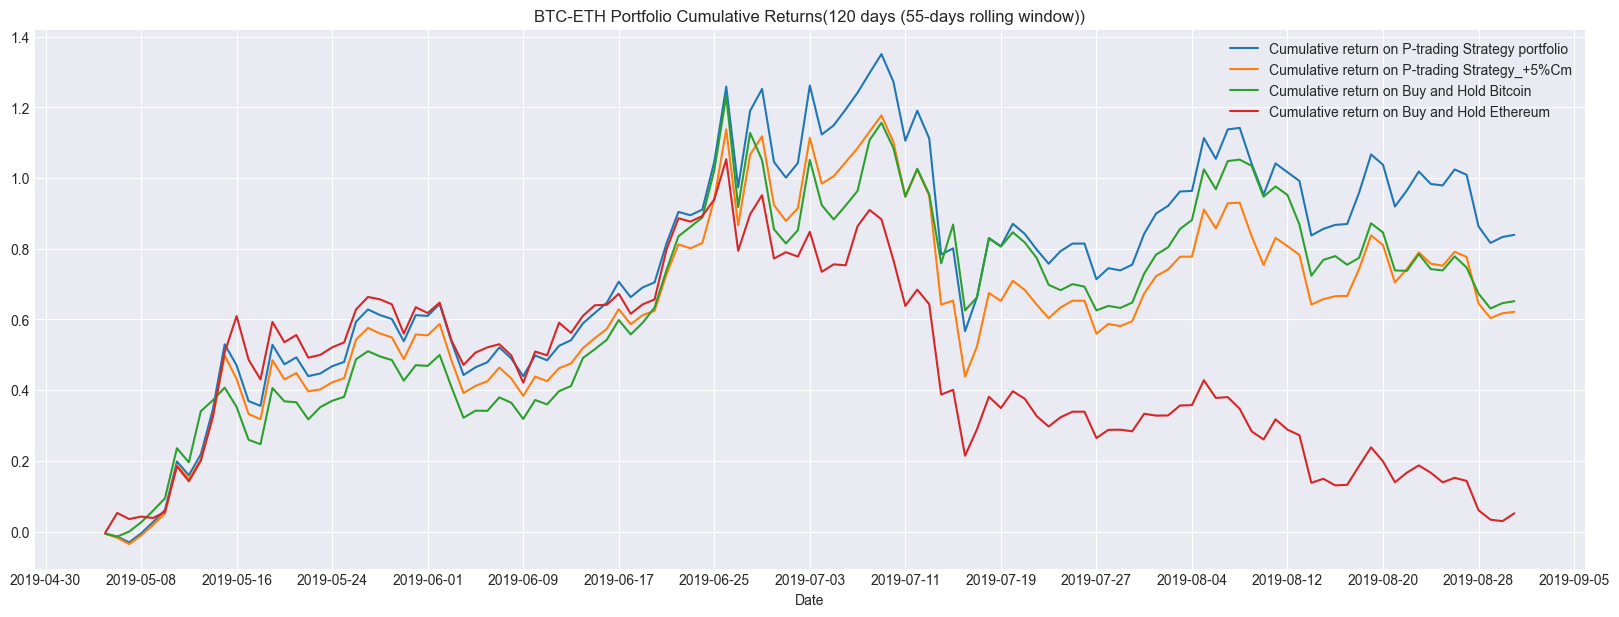

In [34]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.plot(pt_out, label='Cumulative return on P-trading Strategy portfolio') 
plt.plot(pt_outc, label='Cumulative return on P-trading Strategy_+5%Cm') 
plt.plot(bh_btc, label='Cumulative return on Buy and Hold Bitcoin') 
plt.plot(bh_eth, label='Cumulative return on Buy and Hold Ethereum') 
plt.title('BTC-ETH Trading Strategy Cumulative returns') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.title('BTC-ETH Portfolio Cumulative Returns(120 days (55-days rolling window))') 
ax.legend(loc='best')
ax.grid(True)
plt.show() 

## 19. BTC-ETH Strategy Performance Summary

In [35]:
results2 = [{'0': 'Test-Period:', '1': 'P-Trading Strategy', '2': 'P-Trading Strategy_+5%Cm', '3': 'Buy&Hold Bitcoin', '4': 'Buy&Hold Ethereum'},
        {'0': 'Return', '1': np.round(pt_out[-1], 4),
         '2':np.round(pt_outc[-1], 4),
         '3': np.round(bh_btc[-1], 4),
         '4': np.round(bh_eth[-1], 4)},
        {'0': 'Standard Deviation', '1': np.round(np.std(pt_out) , 4),
         '2': np.round(np.std(pt_outc), 4),
         '3': np.round(np.std(bh_btc), 4),
         '4': np.round(np.std(bh_eth), 4)},
        {'0': 'Sharpe Ratio (Rf=0%)', '1': np.round(pt_out[-1] / (np.std(pt_out)), 4),
         '2': np.round(pt_outc[-1] / (np.std(pt_outc) ), 4),
         '3': np.round(bh_btc[-1] / (np.std(bh_btc)), 4),
         '4': np.round(bh_eth[-1] / (np.std(bh_eth) ), 4)}]
table2 = pd.DataFrame(results2)
print('')
print('== BTC_ETH Strategy Performance Summary ==')
print('') 
print(table2) 


== BTC_ETH Strategy Performance Summary ==

                      0                   1                         2  \
0          Test-Period:  P-Trading Strategy  P-Trading Strategy_+5%Cm   
1                Return              0.8393                    0.6214   
2    Standard Deviation              0.3138                    0.2611   
3  Sharpe Ratio (Rf=0%)              2.6747                    2.3797   

                  3                  4  
0  Buy&Hold Bitcoin  Buy&Hold Ethereum  
1            0.6516             0.0515  
2            0.2809             0.2547  
3            2.3198             0.2021  


## 20. Analysing Profitabiliy of the Strategy

In [36]:
Max_ret=pd.Series.max(pair_test['port_out'], axis=None, numeric_only=None) 
Min_ret=pd.Series.min(pair_test['port_out'], axis=None,  numeric_only=None)
Min_cret=pd.Series.min(pt_out, axis=None, numeric_only=None)

Min_ret_count=len(pair_test['port_out'].loc[(pair_test['port_out'] < 0)]) 
Max_ret_count =len(pair_test['port_out'].loc[(pair_test['port_out'] > 0)]) 
Optimal_trade=((Max_ret_count)/(len(pair_test['port_out'])))*100
print('='*10+'Analyzing Profitability Strategy'+'='*10)
print()
print('Maximum Return per time for this portfolio is',(np.round(Max_ret,2)))
print('Minimum Return per time for this portfolio is',(np.round(Min_ret,2)))
print('Minimum Cumulative Returns  for this portfolio is',(np.round(Min_cret,2)))
print('Profitability of the paired Trading Strategy is',(np.round(Optimal_trade,2)),'%')
print('trade with consideration of hedge ',(np.round(beta,2)),'%','beta','that is 100 value avaliable to bitcoin and ',(np.round(beta*100,0)),' to Ethereum')

==========Analyzing Profitability Strategy==========

the Maximum Return per time for this portfolio is 0.14
the Minimum Return per time for this portfolio is -0.16
the Minimum Cumulative Returns  for this portfolio is -0.03
the Profitability of the paired Trading Strategy is 59.66 %
trade with consideration of hedge  0.61 % beta that is 100 value avaliable to bitcoin and  61.0  to Ethereum
